- KEYWORDS: scipy.integrate.solve_bvp, numpy.polyfit


## Solving nonlinear BVPs by finite differences



Adapted from Example 8.7 in <span class="underline">Numerical Methods in Engineering with Python</span> by Jaan Kiusalaas.

We want to solve $y''(x) = -3 y(x) y'(x)$ with $y(0) = 0$ and $y(2) = 1$.

This is a boundary value problem *not an initial value problem*. First we consider using a finite difference method. We discretize the region and approximate the derivatives as:

$y''(x) \approx \frac{y_{i-1} - 2 y_i + y_{i+1}}{h^2} $

$y'(x) \approx \frac{y_{i+1} - y_{i-1}}{2 h} $

We define a function $y''(x) = F(x, y, y')$. At each node in our discretized region, we will have an equation that looks like $y''(x) - F(x, y, y') = 0$, which will be nonlinear in the unknown solution $y$. The set of equations to solve is:

\begin{eqnarray}
y_0 - \alpha &=& 0 \\
\frac{y_{i-1} - 2 y_i + y_{i+1}}{h^2} + (3 y_i) (\frac{y_{i+1} - y_{i-1}}{2 h}) &=& 0 \\
y_L - \beta &=&0
\end{eqnarray}

Since we use a nonlinear solver, we will have to provide an initial guess to the solution. We will in this case assume a line. In other cases, a bad initial guess may lead to no solution.



In [1]:
import numpy as np
from scipy.optimize import fsolve
%matplotlib inline
import matplotlib.pyplot as plt

x1 = 0.0
x2 = 2.0

alpha = 0.0
beta = 1.0

# Out [1]:

We need to specify a grid of points to discretize the solution on. We will start with a small grid because it is easy to visualize, but note that the grid spacing determines how good the approximation to the derivative is, so we will have to return here to see what the impact of our spacing is.



In [1]:
N = 10
X, h = np.linspace(x1, x2, N, retstep=True)

# Out [2]:

Now, we can define functions for the differential equation, and for the nonlinear equations.



In [1]:
def residuals(y):
    "When we have the right values of y, this function will be zero."

    res = np.zeros(y.shape) # we need a zero for each node

    res[0] = y[0] - alpha # this is the boundary value y(alpha) = 0

    for i in range(1, N - 1):
        x = X[i]
        # Approximation of y'' from the current point
        YPP = (y[i - 1] - 2 * y[i] + y[i + 1]) / h**2

        # Approximation of y'
        YP = (y[i + 1] - y[i - 1]) / (2 * h)

        # y'' + 3 * y * y' = 0
        res[i] = YPP + 3 * y[i] * YP

    res[-1] = y[-1] - beta # y(beta) = 0

    return res

# Out [3]:

We need a guess, and here we guess a line. It is always a good idea to plot your guess just to make sure it does what you want. Here, we want it to have the right boundary values.



# Out [4]:
# text/plain

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

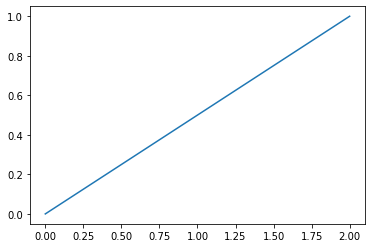

In [1]:
# we need an initial guess
init = alpha + (beta - alpha) / (x2 - x1) * X
plt.plot(X, init)

We should check our residuals function. We mostly want to see that it runs, and produces the right shaped output.



In [1]:
residuals(init)

# Out [5]:
# text/plain
array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        , 1.16666667, 1.33333333, 0.        ])

Now, we solve the BVP.



# Out [6]:
# output
The solution converged.

# text/plain
Text(0, 0.5, 'y')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

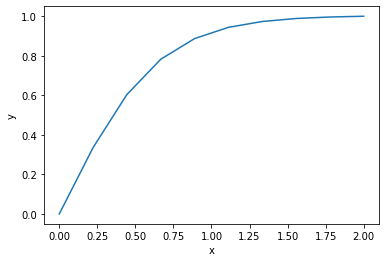

In [1]:
Y, info, status, msg = fsolve(residuals, init, full_output=1)
print(msg)

plt.plot(X, Y)
plt.xlabel('x')
plt.ylabel('y')

The solution is has some apparent discontinuities because we only used about 10 points. How can you tell if the solution is correct? We can estimate the derivatives, and see how well they fit the equation. We look for:

$y'' + 3 y y' = 0$ for all $x$.



# Out [7]:
# text/plain
Text(0, 0.5, 'residuals')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

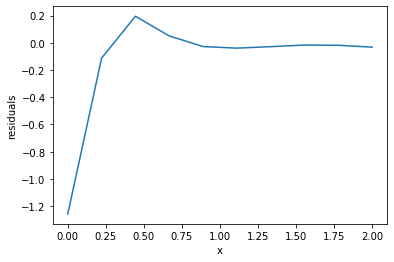

In [1]:
yp = np.gradient(Y, X, edge_order=2)
ypp = np.gradient(yp, X, edge_order=2)

plt.plot(X, ypp + 3 * Y * yp)
plt.xlabel('x')
plt.ylabel('residuals')

This result doesn't look great at the origin, but remember:

1.  we used a coarse grid, so the derivative *approximations* are probably not that accurate
2.  Numerical derivatives at the end-points are less accurate than in the middle.

**exercise** Go back and repeat this for a finer grid, e.g. with 50, 100 points.

The approach described here is pretty general. Here, we were able to solve a second-order BVP by discretizing it, approximating the derivatives at the points, and solving the corresponding nonlinear algebra equations. This approach can be extended in a variety of ways, including to systems of equations, and to 2D or 3D systems (where this approach is called finite-element). You will see these kinds of problems extensively in the spring semster in the Transport class.

As we have seen before, however, there are functions in `scipy` that can help solve these problems.



## Introduction to solve_bvp



In [1]:
from scipy.integrate import solve_bvp

solve_bvp?

# Out [8]:

### A worked bvp problem



In the pressure driven flow of a fluid with viscosity $\mu$ between two stationary plates separated by distance $d$ and driven by a pressure drop $\Delta P/\Delta x$, the governing equations on the velocity $u$ of the fluid are (assuming flow in the x-direction with the velocity varying only in the y-direction):

$$\frac{\Delta P}{\Delta x} = \mu \frac{d^2u}{dy^2}$$

with boundary conditions $u(y=0) = 0$ and $u(y=d) = 0$, i.e. the no-slip condition at the edges of the plate.

we convert this second order BVP to a system of ODEs by letting $u_1 = u$, $u_2 = u_1'$ and then $u_2' = u_1''$. This leads to:

$\frac{d u_1}{dy} = u_2$

$\frac{d u_2}{dy} = \frac{1}{\mu}\frac{\Delta P}{\Delta x}$

with boundary conditions $u_1(y=0) = 0$ and $u_1(y=d) = 0$.

for this problem we let the plate separation be d=0.1, the viscosity $\mu = 1$, and $\frac{\Delta P}{\Delta x} = -100$.



In [1]:
import numpy as np

d = 0.1
mu = 1
deltaPdeltax = -100

# Out [9]:

The function defining the BVP has to return an array that has a row for each equation, and a column for each value in the grid.



In [1]:
def bvp(y, U):
    u1, u2 = U
    du1dy = u2
    du2dy = np.ones(y.shape) / mu * deltaPdeltax
    return [du1dy, du2dy]

:results:
 # Out [10]:
 :end:

The boundary condition function will get the whole numeric solution at each boundary. We want $u1(a) = 0$ and $u1(b)=0$.



In [1]:
def bc(Ua, Ub):
    u1a, u2a = Ua
    u1b, u2b = Ub
    return [u1a, u1b]

:results:
 # Out [11]:
 :end:

Next, we need an initial guess for u1 and u2 on a grid of points. You have to make some decisions here. You need a guess that is reasonably close, but not hard to construct. Here, we anticipate a solution that looks parabolic, and that goes through the points: (0, 0), (d, 0), and some point at (d / 2, ?), where ? represents the point of maximum velocity in middle. We can easily get this polynomial with np.polyfit.



In [1]:
?np.polyfit

# Out [12]:

We don't know what the maximum velocity is, so we make a guess, say 0.5. Then, we get the parameters, and apply them to an array of y values.



In [1]:
pars = np.polyfit([0, d / 2, d],  # x-points
                  [0, 0.5, 0],    # y-points
                  2)              # polynomial order
pars

:results:
 # Out [14]:
 # text/plain
 : array([-2.00000000e+02,  2.00000000e+01, -4.48803257e-16])
 :end:

Now, we can define a Y grid and define the guess for the first U1.



In [1]:
Y = np.linspace(0, d)

U1 = np.polyval(pars, Y)

:results:
 # Out [15]:
 :end:

We also need a guess for U2, and in this case we know that $u2 = u1'$, so we just use that.



In [1]:
U2 = np.gradient(U1, Y, edge_order=2)

U = np.array([U1, U2])
print(U.shape)

:results:
 # Out [16]:
 # output
 (2, 50)

 :end:

You should *always* visualize the guess to make sure it does what you want. It is **hard** to make these!



:results:
 # Out [17]:


 # text/plain
 : <Figure size 432x288 with 2 Axes>

 # image/png
 
 :end:

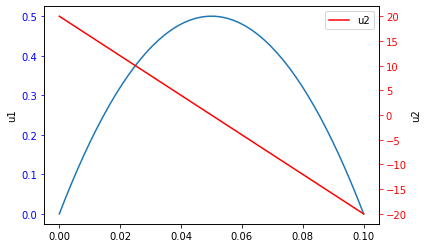

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(Y, U[0], label='u1')
plt.gca().tick_params('y', colors='b')
plt.ylabel('u1')

plt.twinx()
plt.plot(Y, U[1], 'r', label='u2')
plt.gca().tick_params('y', colors='r')
plt.ylabel('u2')
plt.legend()

Now, we are ready to solve the BVP.



:results:
 # Out [18]:
 # output
 The algorithm converged to the desired accuracy.

 # text/plain
 : Text(0, 0.5, 'U')

 # text/plain
 : <Figure size 432x288 with 1 Axes>

 # image/png
 
 :end:

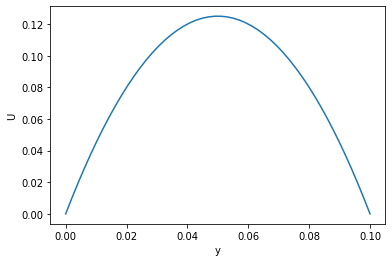

In [1]:
from scipy.integrate import solve_bvp

sol = solve_bvp(bvp, bc, Y, U)
print(sol.message)
plt.plot(sol.x, sol.y[0])
plt.xlabel('y')
plt.ylabel('U')

**exercise** Try using different guesses, e.g. lines, or triangle shapes, etc. What else looks like this shape? Half a cycle of a sin wave? A semi-circle?

**exercise** How can you show this is a solution to the BVP?



### Concentration profile in a particle



Another typical boundary value problem in chemical engineering is the concentration profile inside a catalyst particle. Here is the dimensionless equation for a second order reaction in a slab. Note here we have a boundary condition on the derivative at the origin. This kind of condition means either there is no flux at this position, or that the slab is symmetric about this position.

$\frac{d^2c}{dx^2} = \Phi^2 c^2$

with $c'(0)$ = 0 and $c(1) = 1$

We again convert this to a system of first order differential equations like this:

Let c1 = c, c1' = c', and c2 = c1', so c2' = c1'' = c''

Then we have:

$c1' = c2$

$c2' = \Phi^2 c1^2$

with boundary conditions $c1'(0) = 0$ and $c1(0) = 1$.

We begin with the required functions:



In [1]:
Phi = 50

def bvp(x, C):
    c1, c2 = C
    dc1dx = c2
    dc2dx = Phi**2 * c1**2
    return [dc1dx, dc2dx]

def bc(Ca, Cb):
    c1a, c2a = Ca
    c1b, c2b = Cb

    # Now, evaluate the derivatives at the first boundary condition
    c1prime, c2prime = bvp(0, [c1a, c2a])
    return [c1prime,  # will all equal zero
            c1b - 1]  # c1(b) = 1

:results:
 # Out [19]:
 :end:

We need an initial guess. We make a naive one, that $c(x) = 1$ in the slab, i.e. there is no reaction. As usual, we visualize the guess to be sure it does what we intended.



:results:
 # Out [20]:
 # text/plain
 : [<matplotlib.lines.Line2D at 0x181eab7110>]

 # text/plain
 : <Figure size 432x288 with 1 Axes>

 # image/png
 
 :end:

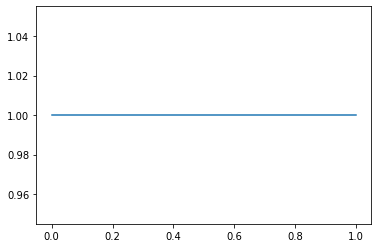

In [1]:
X = np.linspace(0, 1)

C1 = np.ones(X.shape)
C2 = np.gradient(C1, X)

plt.plot(X, C1)

Now we solve the system.



In [1]:
C = [C1, C2]
sol = solve_bvp(bvp, bc, X, C)
sol.message

:results:
 # Out [21]:
 # text/plain
 : 'The algorithm converged to the desired accuracy.'
 :end:

:results:
 # Out [22]:
 # text/plain
 : (0, 1)

 # text/plain
 : <Figure size 432x288 with 1 Axes>

 # image/png
 
 :end:

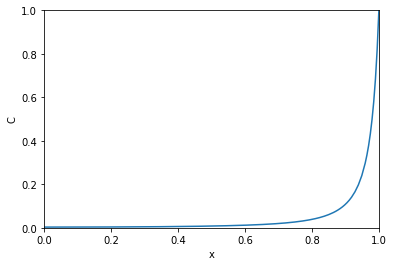

In [1]:
plt.plot(sol.x, sol.y[0])
plt.xlabel('x')
plt.ylabel('C')
plt.xlim([0, 1])
plt.ylim([0, 1])

You can see the solution looks nothing like our initial guess. In this case, a high thiele modulus means most of the reaction happens near the catalyst surface, and the interior of the slab has hardly any reactant in it. This solution is consistent with that.

The effectiveness factor for this system is defined by:

$E = \int_0^1 c^2 dx$

We can estimate this with the trapezoid or Simpson's method (remember that the solution is a vector of numbers).



In [1]:
c = sol.y[0]
print(np.trapz(c**2, sol.x))

from scipy.integrate import simps
print(simps(c**2, sol.x))

# Out [23]:
# output
0.016528962860989847
0.01633462094482091

Or, we can use the dense\_output of the solution with quad.



In [1]:
from scipy.integrate import quad

def integrand(x):
    c1, c2 = sol.sol(x)
    return c1**2

quad(integrand, 0, 1)

# Out [24]:
# text/plain
(0.01632998588357348, 9.76148224805893e-09)

**excercise** Repeat this example for different values of &Phi;.

**exercise** Try different kinds of guesses. Think of a guess that has the properties of the boundary conditions, e.g. c'(0) = 0, and c(1) = 1.

**exercise** Evaluate the quality of the solution based on the equations.



## Summary



Today, we leveraged the ability to solve systems of nonlinear algebraic equations to solve boundary value problems by discretizing them on a grid, approximating them at the grid points, and then solving the resulting nonlinear equations.

We also learned about the solve\_bvp function, which is in scipy.integrate to solve systems of first-order boundary value problems.

Next time, we will return to nonlinear algebra to see how the algorithms can be used to find minima and maxima.

